## 1. Introduction
Our dataset is a list of housing listings from the top 45 most populous cities in canada. We felt that it would be interesting and relevant (since we are first years looking for housing) to study this data and identify patterns in it. Our goal is to create a regression model that can predict price using number of beds, number of baths, and median income as predictors.

## 2. Tidying and Wrangling

In [40]:
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 6)
library(ggrepel)

ERROR: Error in library(ggrepel): there is no package called ‘ggrepel’


We load our data into a tibble 

In [3]:
housing_raw <- read_csv("data/HouseListings-Top45Cities-10292023-kaggle.csv") |> clean_names()
housing_raw

Rows: 35768 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): City, Address, Province
dbl (7): Price, Number_Beds, Number_Baths, Population, Latitude, Longitude, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


city,price,address,number_beds,number_baths,province,population,latitude,longitude,median_family_income
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Toronto,779900,#318 -20 SOUTHPORT ST,3,2,Ontario,5647656,43.7417,-79.3733,97000
Toronto,799999,#818 -60 SOUTHPORT ST,3,1,Ontario,5647656,43.7417,-79.3733,97000
Toronto,799900,#714 -859 THE QUEENSWAY,2,2,Ontario,5647656,43.7417,-79.3733,97000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Halifax,419900,212 60 Walter Havill Drive,2,2,Nova Scotia,431479,44.8857,63.1005,86753
Halifax,949900,10 Idlewylde Road,3,1,Nova Scotia,431479,44.8857,63.1005,86753
Halifax,592900,208 2842-2856 Gottingen,2,1,Nova Scotia,431479,44.8857,63.1005,86753


This tibble is already tidy, so we can get down to summarizing and visualizing data

Address, latitude, and longitude won't help us make a prediction, so let's remove them. Additionally it's important to note that median_family_income and population are only unique to the city, and so exist only to assign a numeric value to each city

In [4]:

filter(housing_raw, number_beds == 0 | number_baths == 0)

city,price,address,number_beds,number_baths,province,population,latitude,longitude,median_family_income
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Toronto,548000,#2503 -99 HARBOUR SQ,0,1,Ontario,5647656,43.7417,-79.3733,97000
Toronto,459900,#2311 -170 SUMACH ST N,0,1,Ontario,5647656,43.7417,-79.3733,97000
Toronto,499900,#202 -1030 KING ST W,0,1,Ontario,5647656,43.7417,-79.3733,97000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Saskatoon,199000,408-404 C AVENUE S,0,1,Saskatchewan,266141,52.1333,-106.6833,89000
Saskatoon,350000,428 F AVENUE S,0,1,Saskatchewan,266141,52.1333,-106.6833,89000
Saskatoon,84900,19-400 4th AVENUE N,0,1,Saskatchewan,266141,52.1333,-106.6833,89000


These are all wrong (there are no 0 bed houses), so let's remove them from our data so it doesn't skew the model

In [5]:
housing_filter <- housing_raw |> filter(number_beds > 0 & number_baths > 0)
housing_filter

city,price,address,number_beds,number_baths,province,population,latitude,longitude,median_family_income
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Toronto,779900,#318 -20 SOUTHPORT ST,3,2,Ontario,5647656,43.7417,-79.3733,97000
Toronto,799999,#818 -60 SOUTHPORT ST,3,1,Ontario,5647656,43.7417,-79.3733,97000
Toronto,799900,#714 -859 THE QUEENSWAY,2,2,Ontario,5647656,43.7417,-79.3733,97000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Halifax,419900,212 60 Walter Havill Drive,2,2,Nova Scotia,431479,44.8857,63.1005,86753
Halifax,949900,10 Idlewylde Road,3,1,Nova Scotia,431479,44.8857,63.1005,86753
Halifax,592900,208 2842-2856 Gottingen,2,1,Nova Scotia,431479,44.8857,63.1005,86753


While combing through the data we noticed that some cities and provinces had been mislabeled. These were "Saskatoon, Ontario", "Winnipeg, Ontario", "Nanaimo, Ontario", and "Regina, Ontario". We should delete all these problematic rows from the dataset too

In [27]:
housing_clean <- housing_filter |> filter(!(city %in% c("Saskatoon", "Winnipeg", "Nanaimo", "Regina") & province == "Ontario"))

## 3. Preliminary Data Analysis

We felt that the best way to summarize the data would be the find mean house price for each city, and plot that against median income 

`summarise()` has grouped output by 'city', 'province'. You can override using
the `.groups` argument.


city,province,median_family_income,avg_price,average_beds,average_baths
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
White Rock,British Columbia,73000,2218539,3.721030,3.353648
Vancouver,British Columbia,90000,1859215,2.809816,2.500000
Maple Ridge,British Columbia,105000,1501983,3.579403,2.949686
⋮,⋮,⋮,⋮,⋮,⋮
Sault Ste. Marie,Ontario,73000,426020.7,3.250000,2.085366
Saint John,New Brunswick,74000,363543.1,3.490196,2.254902
Regina,Saskatchewan,90000,338303.0,3.160293,2.287585


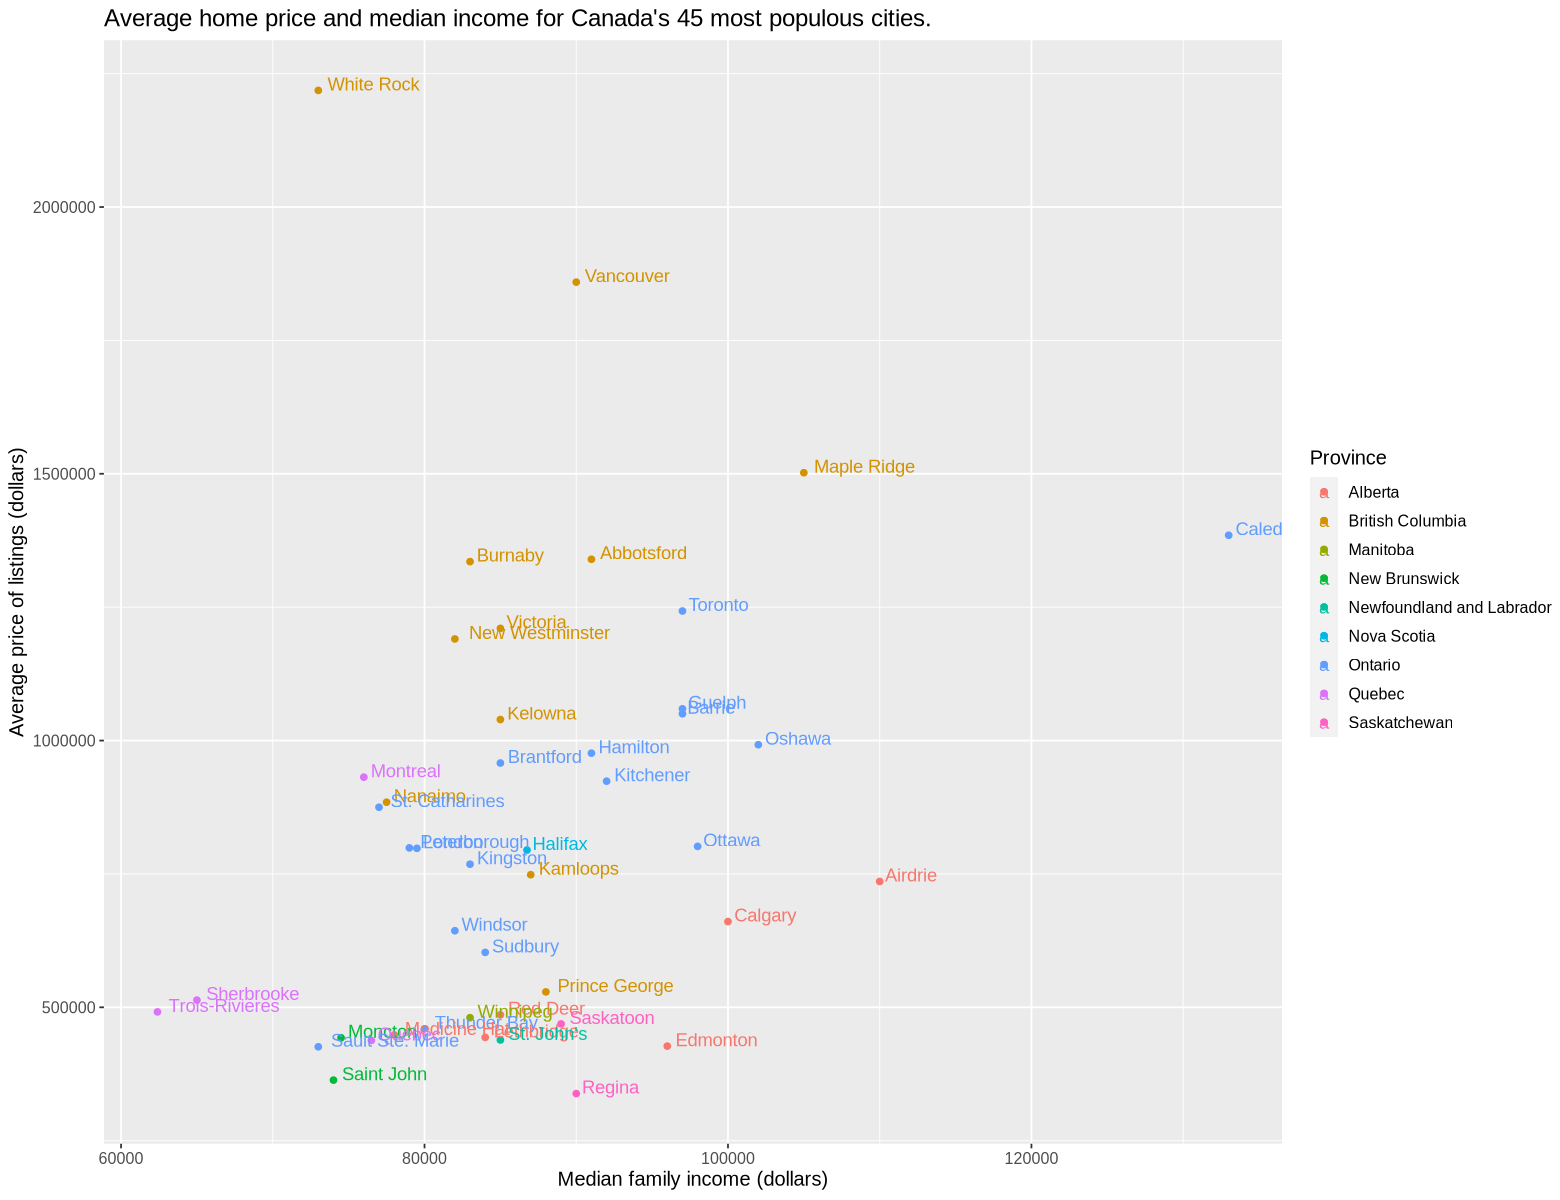

In [75]:
options(repr.plot.height = 10, repr.plot.width = 13)
table_avg_price <- housing_clean |>
group_by(city, province, median_family_income) |>
summarize(avg_price = mean(price), average_beds = mean(number_beds), average_baths = mean(number_baths)) |>
arrange(-avg_price)
table_avg_price


avg_price_plot <- ggplot(table_avg_price, aes(x = median_family_income, y = avg_price, color = province, label = city)) + geom_point() +
                labs(x = "Median family income (dollars)", y = "Average price of listings (dollars)", color = "Province",
                    title = "Average home price and median income for Canada's 45 most populous cities.") + geom_text(hjust = -0.1, vjust = 0) +
                theme(text = element_text(size = 12))
avg_price_plot

Although the graph looks a little messy, we've opted to leave labels on because it givees us a lot of information that we would otherwise have to comb through the table for. For example, White Rock, British Columbia could be considered the "least affordable" (for the average person) city, while Airdrie, Alberta would be the "most affordable" (for the average person).

We wanted to look at the nature of housing supply for each city

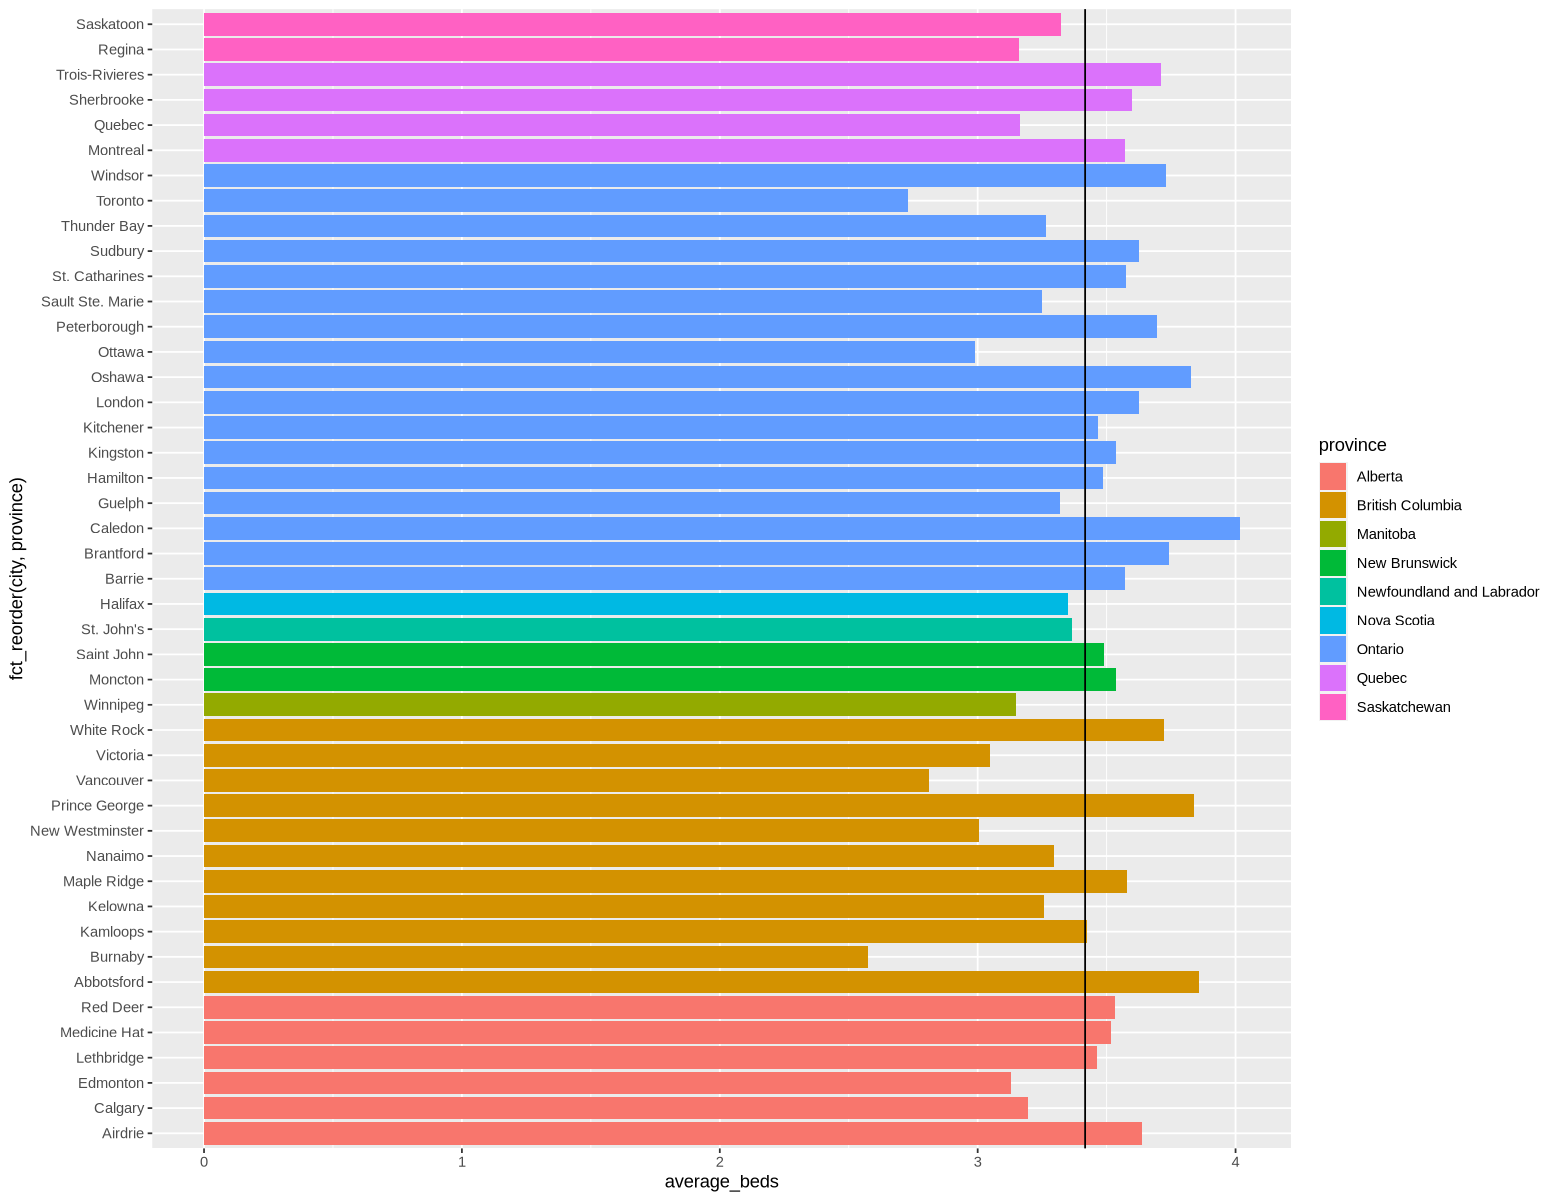

In [90]:
average_bed_plot <- ggplot(table_avg_price, aes(y = fct_reorder(city, province), x = average_beds, fill = province)) +
                    geom_bar(stat = "identity") +
                    geom_vline(xintercept = 3.416648)
average_bed_plot

## 3. Methods

Address, latitude, and longitude won't help us make a prediction, so let's remove them. Additionally it's important to note that median_family_income and population are only unique to the city, and so exist only to assign a numeric value to each city

In [29]:
housing_modelling <- housing_clean |> select(-address, -latitude, -longitude)
housing_modelling

city,price,number_beds,number_baths,province,population,median_family_income
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Toronto,779900,3,2,Ontario,5647656,97000
Toronto,799999,3,1,Ontario,5647656,97000
Toronto,799900,2,2,Ontario,5647656,97000
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Halifax,419900,2,2,Nova Scotia,431479,86753
Halifax,949900,3,1,Nova Scotia,431479,86753
Halifax,592900,2,1,Nova Scotia,431479,86753


## 4. Expected findings and significance